In [1]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv


# Load libraries
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('weatherAUS.csv')

In [3]:
print(df.shape)
print(df.dtypes) #(row,column)

(145460, 23)
Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object


In [4]:

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)


['MinTemp' 'MaxTemp' 'Rainfall' 'Evaporation' 'Sunshine' 'WindGustSpeed'
 'WindSpeed9am' 'WindSpeed3pm' 'Humidity9am' 'Humidity3pm' 'Pressure9am'
 'Pressure3pm' 'Cloud9am' 'Cloud3pm' 'Temp9am' 'Temp3pm']
['Date' 'Location' 'WindGustDir' 'WindDir9am' 'WindDir3pm' 'RainToday'
 'RainTomorrow']


In [5]:

# if it's a larger dataset and the visualization takes too long can do this.
# % of missing.
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Date - 0%
Location - 0%
MinTemp - 1%
MaxTemp - 1%
Rainfall - 2%
Evaporation - 43%
Sunshine - 48%
WindGustDir - 7%
WindGustSpeed - 7%
WindDir9am - 7%
WindDir3pm - 3%
WindSpeed9am - 1%
WindSpeed3pm - 2%
Humidity9am - 2%
Humidity3pm - 3%
Pressure9am - 10%
Pressure3pm - 10%
Cloud9am - 38%
Cloud3pm - 41%
Temp9am - 1%
Temp3pm - 2%
RainToday - 2%
RainTomorrow - 2%


In [6]:
del df['Date']

In [83]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [84]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

for col in numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        med = df[col].median()
        df[col] = df[col].fillna(med)

In [10]:
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

for col in non_numeric_cols:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        
        top = df[col].describe()['top'] # impute with the most frequent value.
        df[col] = df[col].fillna(top)

In [11]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.192053,23.215962,2.307990,5.179779,7.989889,39.962189,14.030751,18.669758,68.901251,51.553396,1017.644768,1015.250115,4.659755,4.709913,16.987101,21.668916
std,6.365780,7.088358,8.389771,3.178819,2.757790,13.120931,8.861796,8.716716,18.855360,20.471345,6.728484,6.663994,2.281490,2.106768,6.449299,6.850658
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.700000,18.000000,0.000000,4.000000,8.200000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.500000,1011.100000,3.000000,4.000000,12.300000,16.700000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.600000,5.200000,8.700000,46.000000,19.000000,24.000000,83.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.500000,26.200000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [58]:


IQR = df.Temp3pm	.quantile(0.75) - df.Temp3pm.quantile(0.25)
Lower_fence = df.Temp3pm.quantile(0.25) - (IQR * 3)
Upper_fence = df.Temp3pm.quantile(0.75) + (IQR * 3)
print('Evaporation outliers are values < {lowerboundary} or > {upperboundary}'.format(
    lowerboundary=Lower_fence, upperboundary=Upper_fence))

Evaporation outliers are values < -4.0999999999999925 or > 37.89999999999999


In [61]:
df[(df.Temp3pm	< Lower_fence) | (df.Temp3pm> Upper_fence)]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow


In [60]:
df.drop(df[ (df.Temp3pm> Upper_fence) | (df.Temp3pm < Lower_fence) ].index , inplace=True)

In [62]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000,20994.000000
mean,7.907254,18.262732,0.432162,1.969110,6.366524,35.452748,12.052968,16.514099,77.215395,56.240640,1021.446513,1018.937728,4.591169,4.828141,12.129056,17.113723
std,4.830546,4.399105,0.780948,0.798778,3.191817,12.270312,7.584840,7.905742,13.802653,16.128196,7.101449,7.129945,2.562067,2.296113,4.524684,4.349152
min,-8.000000,4.100000,0.000000,0.400000,0.000000,9.000000,0.000000,0.000000,13.000000,3.000000,983.700000,987.100000,0.000000,0.000000,-1.200000,3.700000
25%,4.600000,15.000000,0.000000,1.400000,3.900000,26.000000,7.000000,11.000000,68.000000,45.000000,1017.125000,1014.600000,2.000000,3.000000,9.200000,13.900000
50%,7.600000,17.700000,0.000000,2.000000,7.300000,33.000000,11.000000,15.000000,78.000000,55.000000,1022.000000,1019.400000,5.000000,5.000000,11.700000,16.700000
75%,10.700000,20.900000,0.400000,2.600000,8.700000,41.000000,17.000000,20.000000,88.000000,67.000000,1026.300000,1023.900000,7.000000,7.000000,14.700000,19.900000
max,27.500000,38.200000,3.200000,3.200000,14.200000,85.000000,46.000000,46.000000,100.000000,100.000000,1040.900000,1038.900000,8.000000,8.000000,31.200000,37.500000


In [68]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6097,Cobar,16.5,27.4,1.6,2.0,10.0,E,30.0,E,ESE,...,69.0,53.0,1009.0,1006.2,3.0,6.0,20.1,27.0,Yes,No
6151,Cobar,16.2,23.9,0.0,1.8,4.4,ENE,24.0,ESE,E,...,92.0,71.0,1020.6,1016.4,7.0,7.0,18.9,22.1,No,No
6152,Cobar,15.1,24.1,0.4,2.2,6.2,SSW,19.0,N,SSW,...,94.0,61.0,1016.4,1013.6,7.0,6.0,16.5,23.8,No,No
6153,Cobar,14.5,28.4,0.0,2.8,11.1,WNW,39.0,NW,WSW,...,56.0,23.0,1014.6,1012.0,0.0,1.0,22.0,27.4,No,No
6168,Cobar,3.7,17.0,0.0,3.2,8.4,W,39.0,S,S,...,54.0,32.0,1022.9,1020.1,0.0,5.0,9.8,16.8,No,No


In [69]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6097,Cobar,16.5,27.4,1.6,2.0,10.0,E,30.0,E,ESE,...,69.0,53.0,1009.0,1006.2,3.0,6.0,20.1,27.0,Yes,No
6151,Cobar,16.2,23.9,0.0,1.8,4.4,ENE,24.0,ESE,E,...,92.0,71.0,1020.6,1016.4,7.0,7.0,18.9,22.1,No,No
6152,Cobar,15.1,24.1,0.4,2.2,6.2,SSW,19.0,N,SSW,...,94.0,61.0,1016.4,1013.6,7.0,6.0,16.5,23.8,No,No
6153,Cobar,14.5,28.4,0.0,2.8,11.1,WNW,39.0,NW,WSW,...,56.0,23.0,1014.6,1012.0,0.0,1.0,22.0,27.4,No,No
6168,Cobar,3.7,17.0,0.0,3.2,8.4,W,39.0,S,S,...,54.0,32.0,1022.9,1020.1,0.0,5.0,9.8,16.8,No,No


In [ ]:
data_map = df[[target]]
data_map[features] = df[features]
plt.figure(figsize=(15,15))
sns.heatmap(data_map.corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

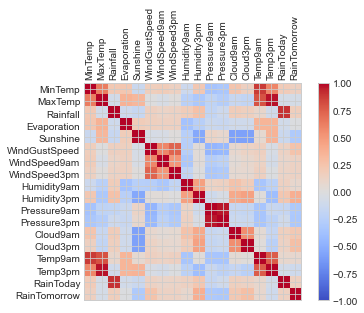

In [88]:
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(numeric_cols),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(numeric_cols)
ax.set_yticklabels(numeric_cols)
plt.show()

In [104]:
X = df['Rainfall'].values
y = df['RainTomorrow'].values

In [107]:
import dill
dill.dump_session('notebook_env.db')

In [2]:
#Başlamadan bunu çalıştırısanız notebook'u yükleyecektir
#pip install dill öncesinde bunu yüklemelisiniz
import dill
dill.load_session('notebook_env.db')